In [87]:
%pip install astronn equinox einops jaxlib fastprogress

Note: you may need to restart the kernel to use updated packages.


In [1]:
from astroNN.datasets import load_galaxy10
#from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion
from astroNN.datasets.galaxy10 import galaxy10_confusion
import numpy as np
import matplotlib.pyplot as plt
#import jax

2024-05-23 20:46:44.048459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch
import torchvision as tv

In [3]:
###Peter
import os

from torchvision.transforms import v2

%matplotlib inline

In [4]:
###Peter
# Just to make the session somewhat determinate
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(0)

In [5]:
###Peter
print(f"CUDA is available: {torch.cuda.is_available()}")

if not torch.cuda.is_available():
    print("If you want, you might want to switch to a GPU-accelerated session!")
    device = torch.device('cpu')
else:
    device = torch.device('cuda')

CUDA is available: False
If you want, you might want to switch to a GPU-accelerated session!


# Galaxy 10 DECals

In [44]:
# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
images, labels = load_galaxy10()

/Users/pbotte/.astroNN/datasets/Galaxy10_DECals.h5 was found!


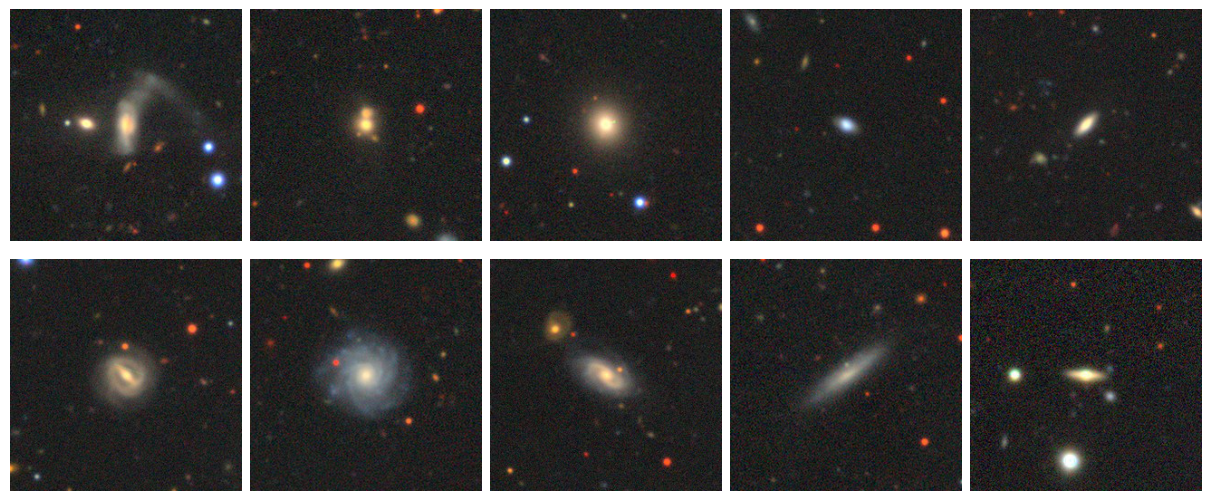

In [45]:
fig, axs = plt.subplots(2, 5, figsize=(12,5), layout='constrained')

for ax, label in zip(np.ravel(axs), range(10)):
    idx = np.where(labels == label)[0][0]
    image = images[idx]

    ax.imshow(image)
    ax.axis('off')
    ###save RAM_ ax.set_title(galaxy10cls_lookup(label))

#### Remove classes that are not Spiral-like

In [46]:
remove_labels = range(5)

for label in remove_labels:
    idx = labels != label
    labels = labels[idx]
    images = images[idx]

In [47]:
del idx

#### Shift labels to 0-4

In [48]:
labels = labels - 5

###Save RAM galaxy10cls_lookup_shift = lambda x: galaxy10cls_lookup(x+5)

#### Rescale images

In [49]:
images.shape

(9796, 256, 256, 3)

In [50]:
#images = jax.vmap(lambda x: x / 255)(images)
images = images / images.max()

# crop the image a bit to get 64x64 shape
def crop_center(images, cropx, cropy):
    _, y, x, _ = images.shape
    startx = x // 2 -(cropx // 2)
    starty = y // 2 -(cropy // 2)
    return images[:, starty:starty+cropy, startx:startx+cropx, :]

images = crop_center(images=images, cropx=64, cropy=64)

In [51]:
images.shape

(9796, 64, 64, 3)

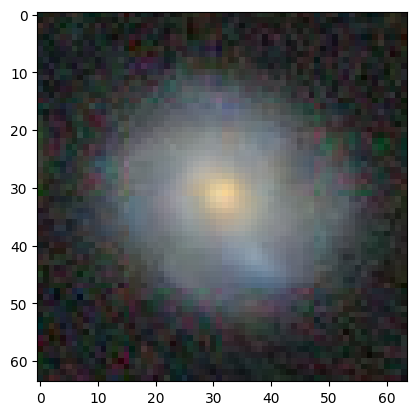

In [52]:
plt.imshow(images[3984])

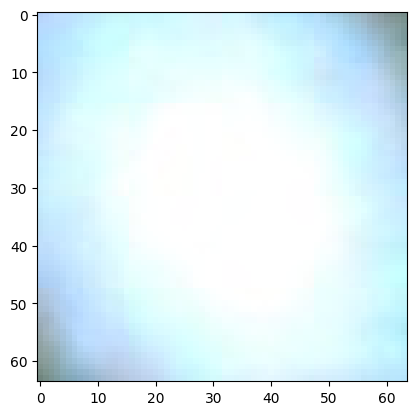

In [53]:
plt.imshow(images[2460])

In [54]:
type(images[2460])

numpy.ndarray

In [55]:
transfo = tv.transforms.Grayscale()

In [63]:
#jax_to_torch(images[3984]).shape

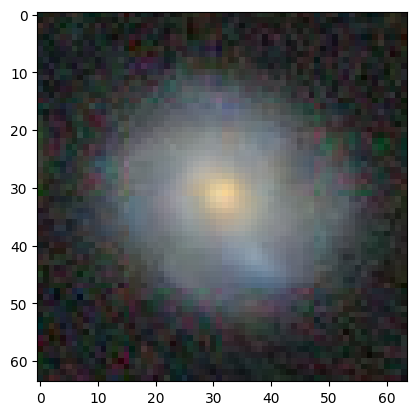

In [62]:
plt.imshow(images[3984])

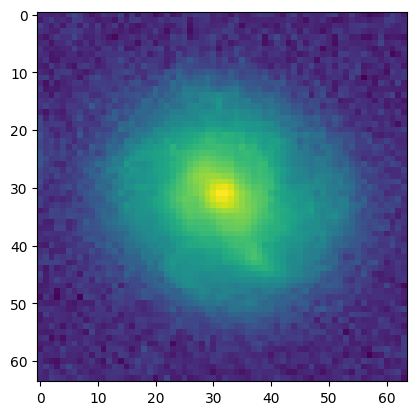

In [61]:
plt.imshow(transfo(torch.tensor(images[3984]).permute(2,0,1)).permute(1,2,0))

In [65]:
images_gray = transfo(torch.tensor(images).permute(0,3,1,2)).permute(0,2,3,1)

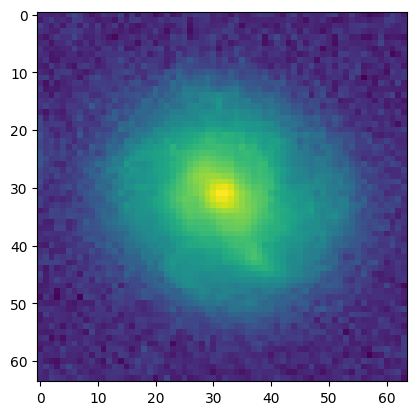

In [66]:
plt.imshow(images_gray[3984])

#### Shuffle images

No randomisation because this gets done in pytorch code later.

In [38]:
#rnd_idx = np.random.choice(range(len(images)), replace=False, size=len(images))
#images = images[rnd_idx]
#labels = labels[rnd_idx]

## Further preparation

In [67]:
type(labels)

numpy.ndarray

In [68]:
labels = torch.tensor(labels)
type(labels)

torch.Tensor

In [69]:
type(images)


numpy.ndarray

In [70]:
images_gray.shape

torch.Size([9796, 64, 64, 1])

In [71]:
images_gray= images_gray[:,:,:,:1].permute(0,3,1,2)

In [73]:
images_gray.shape, labels.shape

(torch.Size([9796, 1, 64, 64]), torch.Size([9796]))

In [74]:
np.where(labels == 1)

(array([2043, 2044, 2045, ..., 3869, 3870, 3871]),)

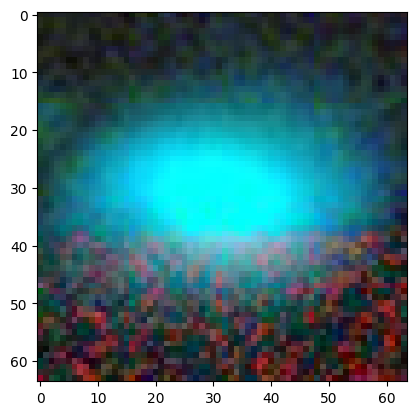

In [77]:
plt.imshow(images[3871])

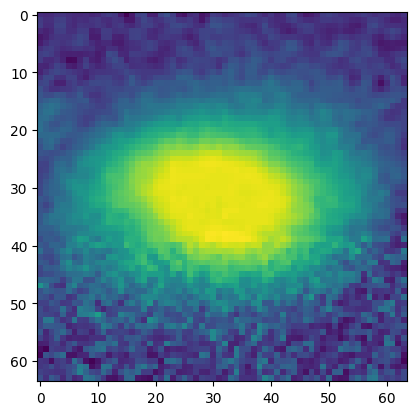

In [75]:
plt.imshow(images_gray[3871].permute(1,2,0))

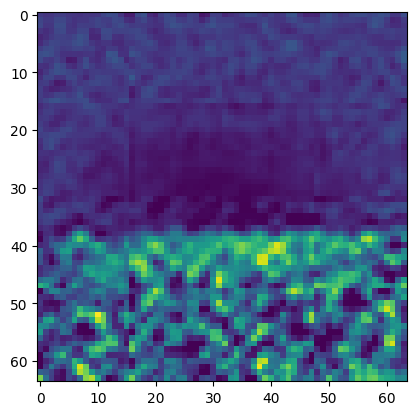

In [34]:
plt.imshow(images[3871].permute(1,2,0))

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

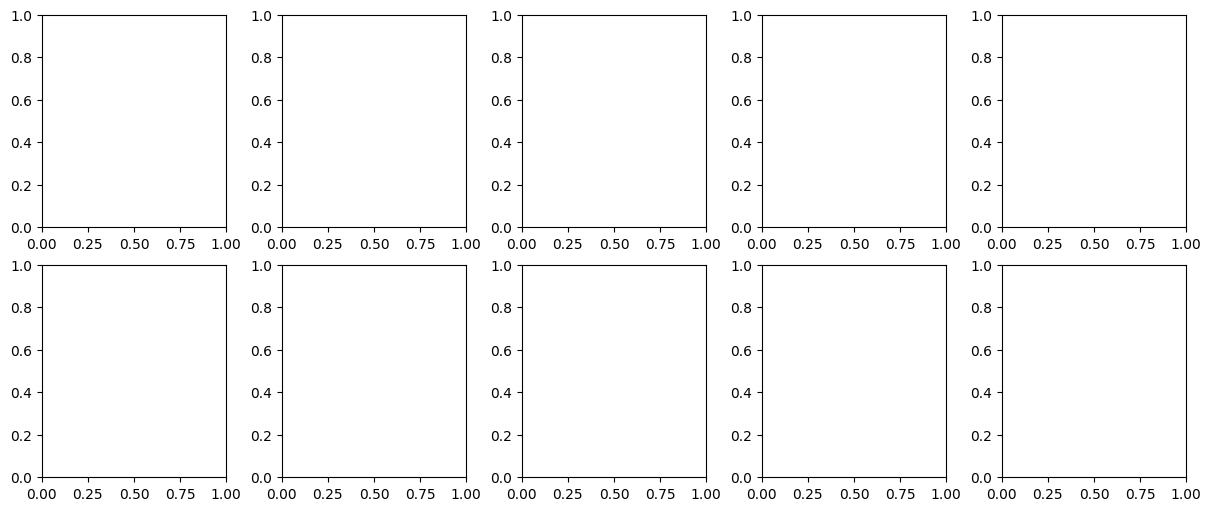

In [78]:
fig, axs = plt.subplots(2, 5, figsize=(12,5), layout='constrained')

for ax, idx in zip(np.ravel(axs), range(10)):
    image = images[idx]
    label = labels[idx]

    ax.imshow(image.permute(1,2,0))
    ax.axis('off')
    ax.set_title(galaxy10cls_lookup_shift(label))

In [79]:
confusion_matrix = np.zeros((5,5))


# create the confusion matrix
for counter, i in enumerate(labels):
    confusion_matrix[i, labels[counter]] += 1

# Plot the confusion matrix
# galaxy10_confusion(confusion_matrix)

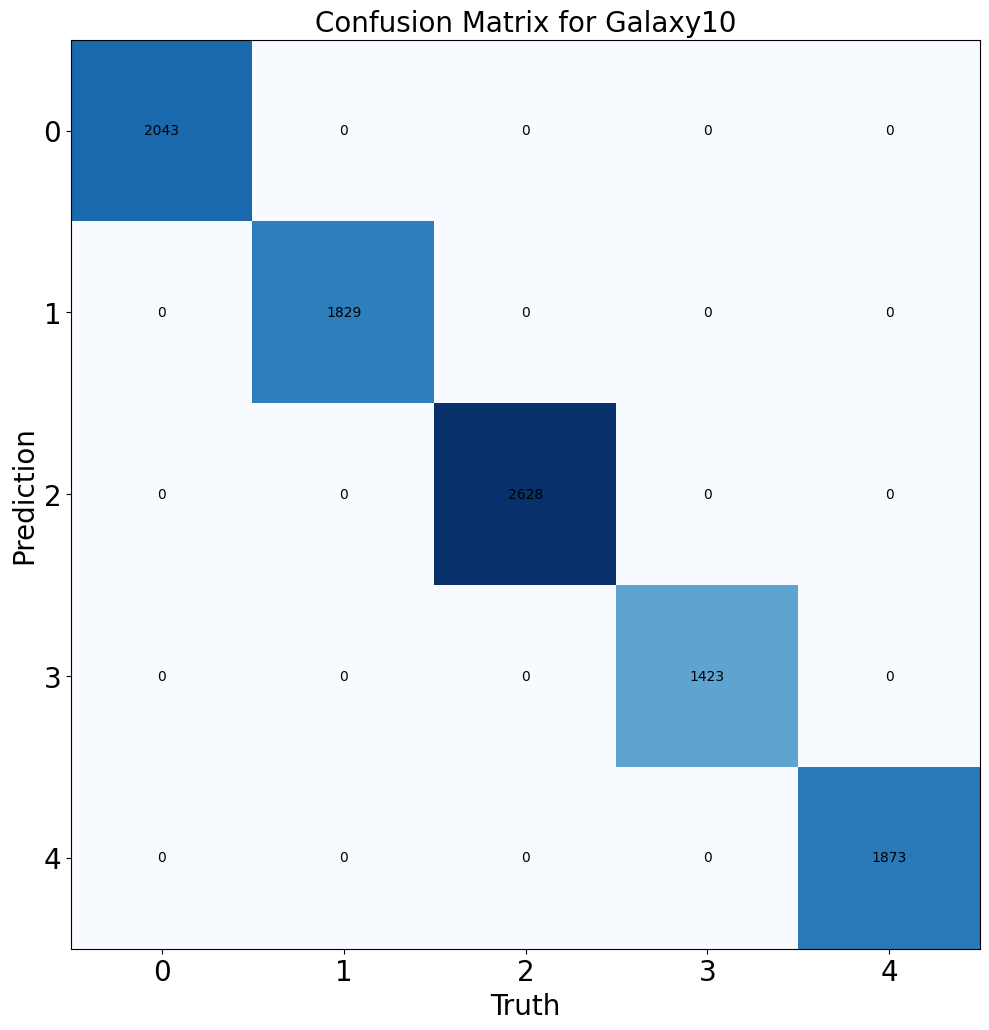

In [41]:
galaxy10_confusion(confusion_matrix)

# Task: Find the galaxy that looks most similar to Milky Way

<img src="https://d2pn8kiwq2w21t.cloudfront.net/original_images/jpegPIA10748.jpg" width=300>

In [80]:
#Download the milkyway picture
!wget https://d2pn8kiwq2w21t.cloudfront.net/original_images/jpegPIA10748.jpg

--2024-05-23 21:28:55--  https://d2pn8kiwq2w21t.cloudfront.net/original_images/jpegPIA10748.jpg
Auflösen des Hostnamens d2pn8kiwq2w21t.cloudfront.net (d2pn8kiwq2w21t.cloudfront.net)… 

/usr/local/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


18.244.20.212, 18.244.20.4, 18.244.20.68, ...
Verbindungsaufbau zu d2pn8kiwq2w21t.cloudfront.net (d2pn8kiwq2w21t.cloudfront.net)|18.244.20.212|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 2049707 (2,0M) [image/jpeg]
Wird in »jpegPIA10748.jpg« gespeichert.

jpegPIA10748.jpg    100%[===================>]   1,95M  7,64MB/s    in 0,3s    

2024-05-23 21:28:57 (7,64 MB/s) - »jpegPIA10748.jpg« gespeichert [2049707/2049707]



In [43]:
#plot the milkyway

In [81]:
milky_way = tv.io.read_image("./jpegPIA10748.jpg").permute(1,2,0).to(torch.float32)
milky_way = milky_way / 255

In [82]:
#read in and plot in low resolution

In [83]:
milky_way = tv.io.read_image("./jpegPIA10748.jpg")
milky_way = tv.transforms.Resize(size=64)(milky_way)
milky_way = milky_way.permute(1,2,0).to(torch.float32)
milky_way = milky_way / 255

In [84]:
type(milky_way), type(image[0])

(torch.Tensor, numpy.ndarray)

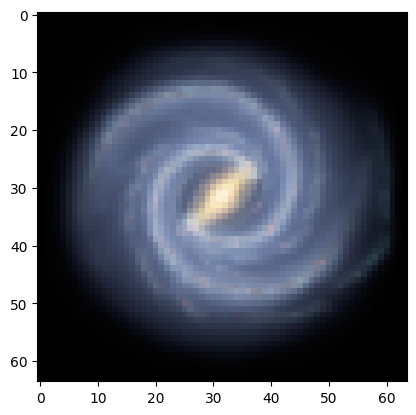

In [85]:
plt.imshow(milky_way.detach().cpu().numpy())

In [49]:
# Model

In [88]:
import fastprogress


def train(dataloader, optimizer, model, loss_fn, device, master_bar,
          transform_common=None, transform_input=None):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress
        transform_common (function): Transform to apply to input and target
        transform_input (function): Transform to apply to the input for de-noising.
            By default, no transform is carried out

    Returns:
        float: Mean loss of this epoch
    """
    epoch_loss = []

    for x, _ in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        x = transform_common(x) if transform_common else x
        x_inp = transform_input(x) if transform_input else x

        # Forward pass
        x = x.to(device)
        x_inp = x_inp.to(device)
        x_hat, mu, logvar = model(x_inp)

        # Compute loss
        loss = loss_fn(x_hat, x, mu, logvar)

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())
        master_bar.child.comment = f"Train Loss: {epoch_loss[-1]:.3f}"

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss)


def validate(dataloader, model, loss_fn, device, master_bar,
             transform_common=None, transform_input=None):
    """Compute loss on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw
            batches and show validation progress
        transform_common (function): Transform to apply to input and target
        transform_input (function): Transform to apply to the input for de-noising.
            By default, no transform is carried out

    Returns:
        float: Mean loss on validation set
    """
    epoch_loss = []

    model.eval()
    with torch.no_grad():
        for x, _ in fastprogress.progress_bar(dataloader, parent=master_bar):
            x = transform_common(x) if transform_common else x

            x_inp = transform_input(x) if transform_input else x

            # make a prediction on test set
            x = x.to(device)
            x_inp = x_inp.to(device)
            x_hat, mu, logvar = model(x_inp)

            # Compute loss
            loss = loss_fn(x_hat, x, mu, logvar)

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())
            master_bar.child.comment = f"Valid. Loss: {epoch_loss[-1]:.3f}"

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss)




def train_model(model, optimizer, loss_function, device, num_epochs,
                train_dataloader, valid_dataloader,
                transform_common=None, transform_input=None):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        valid_dataloader (DataLoader): Torch DataLoader object to load the
            test data
        transform_common (function): Transform to apply to input and target
        transform_input (function): Transform to apply to the input for de-noising.
            By default, no transform is carried out

    Returns:
        list, list: Return list of train losses, test losses.
    """
    master_bar = fastprogress.master_bar(range(num_epochs))
    epoch_list, train_losses, valid_losses = [], [], []

    master_bar.names = ["Train", "Valid."]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss = train(train_dataloader, optimizer, model, loss_function, device, master_bar, transform_common, transform_input)
        # Validate the model
        epoch_valid_loss = validate(valid_dataloader, model, loss_function, device, master_bar, transform_common, transform_input)

        # Save loss and acc for plotting
        epoch_list.append(epoch + 1)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)

        graphs = [[epoch_list, train_losses], [epoch_list, valid_losses]]
        x_bounds = [1, num_epochs]

        master_bar.write(
            f"Epoch {epoch + 1}, "
            f"avg. train loss: {epoch_train_loss:.3f}, "
            f"avg. valid. loss: {epoch_valid_loss:.3f}"
        )
        master_bar.update_graph(graphs, x_bounds)


    return train_losses, valid_losses

In [51]:
#Autoencoder

In [89]:
from torch import nn

class Autoencoder(nn.Module):

    def __init__(self, image_size=64, num_channels=1, latent_dims=128, num_filters=64, do_sampling=False):
        super(Autoencoder, self).__init__()

        self.latent_dims  = latent_dims
        self.image_size   = image_size
        self.num_channels = num_channels
        self.num_filters  = num_filters
        self.do_sampling  = do_sampling

        # Encoder
        self.conv_encoder = nn.Sequential(
            # TODO: Build the convolutional layers (torch.nn.Conv2d) here
            nn.Conv2d(in_channels=num_channels, out_channels=self.num_filters, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.num_filters, out_channels=self.num_filters, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.num_filters, out_channels=self.num_filters, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
        )

        # Linear Encoder
        # TODO: Match the dimensionality of the first and last layer here!
        self.fc_lin_down = nn.Linear(8*8*self.num_filters, 8 * self.num_filters)
        self.fc_mu       = nn.Linear(8 * self.num_filters, self.latent_dims)
        self.fc_logvar   = nn.Linear(8 * self.num_filters, self.latent_dims)
        self.fc_z        = nn.Linear(self.latent_dims, 8 * self.num_filters)
        self.fc_lin_up   = nn.Linear(8 * self.num_filters, 8*8 * self.num_filters)

        # Decoder
        self.conv_decoder = nn.Sequential(
            # TODO: Implement the reverse of the encoder here using torch.nn.ConvTranspose2d layers
            # The last activation here should be a sigmoid to keep the pixel values clipped in [0, 1)
            nn.ConvTranspose2d(in_channels=self.num_filters, out_channels=self.num_filters, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=self.num_filters, out_channels=self.num_filters, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=self.num_filters, out_channels=num_channels, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),

            nn.Sigmoid(),
        )

    def encode(self, x):
        ''' Encoder: output is (mean, log(variance))'''
        x       = self.conv_encoder(x)
        # Here, we resize the convolutional output appropriately for a linear layer
        # TODO: Fill in the correct dimensionality for the reordering
        x       = x.view(-1, self.num_filters * 8 * 8)
        x       = self.fc_lin_down(x)
        x       = nn.functional.relu(x)
        mu      = self.fc_mu(x)
        logvar  = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        ''' Sample from Gaussian with mean `mu` and SD `sqrt(exp(logvarz))`'''
        # Only use the full mean/stddev procedure if we want to later do sampling
        # And only reparametrise if we are in training mode
        if self.training and self.do_sampling:
            std = torch.exp(logvar * 0.5)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu

    def decode(self, z):
        '''Decoder: produces reconstruction from sample of latent z'''
        z = self.fc_z(z)
        z = nn.functional.relu(z)
        z = self.fc_lin_up(z)
        z = nn.functional.relu(z)
        # TODO: Fill in the correct dimensionality for the reordering here again
        z = z.view(-1, self.num_filters, 8, 8)
        z = self.conv_decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        x_hat = self.decode(z)
        if self.do_sampling:
            return x_hat, mu, logvar
        else:
            return x_hat, None, None

In [90]:
def autoencoder_loss(recon_x, x, mu=None, logvar=None):
    mse_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(dim=0)

    if mu is not None and logvar is not None:
        raise NotImplementedError("Looks like you still need to implement the KL divergence loss!")
    else:
        return mse_loss

In [91]:
model = Autoencoder()
model = model.to(device)
learning_rate = 2e-4
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [92]:
model

Autoencoder(
  (conv_encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_lin_down): Linear(in_features=4096, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=128, bias=True)
  (fc_z): Linear(in_features=128, out_features=512, bias=True)
  (fc_lin_up): Linear(in_features=512, out_features=4096, bias=True)
  (conv_decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [93]:
num_epochs = 3

In [94]:
#data preparation

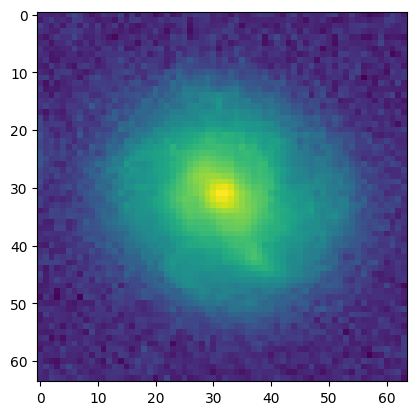

In [102]:
plt.imshow(images_gray[3984].permute(1,2,0))

In [116]:
class Features_Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self._load()

    def _load(self):
        self.images = images_gray.to(torch.float32)
        self.labels = labels.to(torch.float32)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

In [117]:
train_split = 0.6
valid_split = 0.2

full_dataset = Features_Dataset()

test_split = 1 - train_split - valid_split

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_split, valid_split, test_split]
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [118]:
type(labels)

torch.Tensor

In [119]:
#Begin training

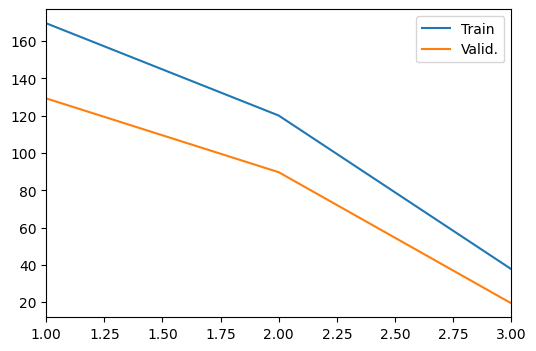

([169.549410280974, 120.07338648257048, 37.7504242606785],
 [129.26529932022095, 89.69157791137695, 19.41792595386505])

In [120]:
train_model(model=model, optimizer=optimizer, loss_function=autoencoder_loss, device=device, num_epochs=num_epochs, train_dataloader=train_loader, valid_dataloader=valid_loader)

In [ ]:
#test results of model

In [122]:
fig_size = 4

def show_images(images, labels=None, num_columns=5, num_rows=3):
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(fig_size * num_columns, fig_size * num_rows),
                        subplot_kw={'xticks': [], 'yticks': []})

    labels = [None] * num_columns * num_rows if labels is None else labels

    for ax, image, label in zip(axs.flat, images, labels):
        # Use a grayscale colourmap if we have only a single channel
        cmap = 'gray' if image.shape[0] == 1 else None

        # Imshow expects HWC, so backtransform here again
        ax.imshow(np.transpose(image, [1, 2, 0]), cmap=cmap)
        if label:
            ax.set_title(f"{label}")

    plt.tight_layout()
    plt.show()

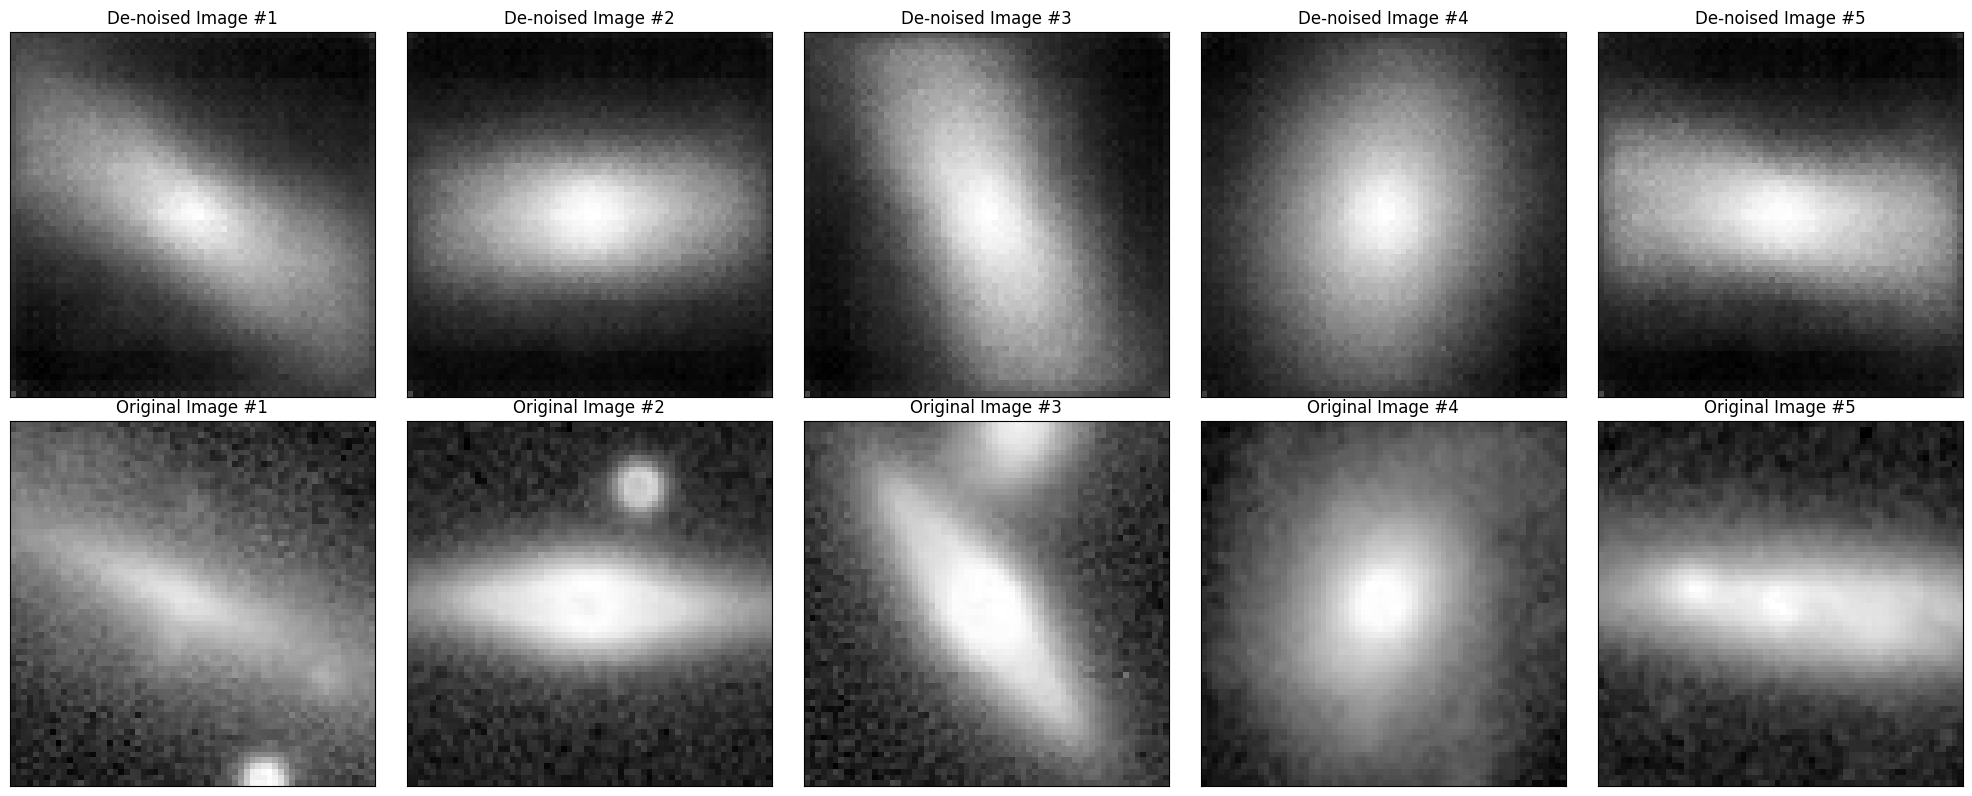

In [123]:
test_images = next(iter(test_loader))[0][:5]

model.eval()
with torch.no_grad():
    denoised_test_images, _, _ = model(test_images.to(device))

denoised_test_images = denoised_test_images.to('cpu')

noise_labels = [f"De-noised Image #{i}" for i in range(1, 6)]\
             + [f"Original Image #{i}" for i in range(1, 6)]
noise_images = torch.cat([denoised_test_images, test_images])

show_images(noise_images, noise_labels, num_rows=2, num_columns=5)

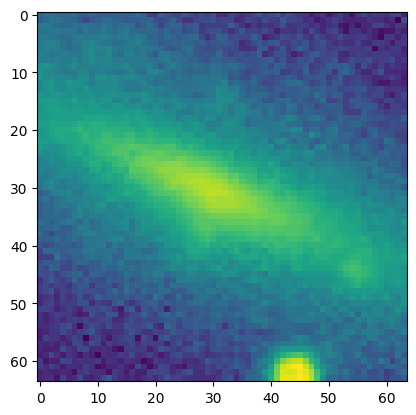

In [135]:
plt.imshow(test_dataset[0][0][0])

## Distance between some images and milkyway

In [137]:
model.encode(images_gray[3984].to(torch.float32))


(tensor([[-0.5220,  1.3349, -2.8383,  0.2681,  4.9163,  2.3512,  2.8537,  3.0065,
           4.0834, -4.8204, -1.2329,  3.2085,  0.0903, -3.8171, -3.2408,  3.1619,
          -1.3593,  2.0560, -0.6479, -1.7714,  1.8129, -0.9843, -0.2828, -3.6543,
           1.8246,  0.3386,  6.3897, -0.2022, -5.6810, -1.2934, -1.2656, -0.2789,
          -0.2451, -0.9802, -2.3309,  2.8033, -0.5391,  3.9764, -1.1403,  1.0982,
          -2.1416,  6.3031, -3.2963,  0.7603, -3.0476, -0.3683, -0.9935,  2.8421,
          -2.5048,  1.5512,  1.1218,  6.0436, -6.4244,  2.5986,  2.8572, -1.4966,
          -1.8965, -2.6170, -2.6092, -2.0327,  0.5033, -0.2694, -3.8784, -0.2479,
           3.8166,  0.7373, -2.3763,  1.6622,  2.8556,  1.3383, -1.8947, -0.5190,
           0.1763, -3.5516, -1.1255, -3.5142,  1.4966,  4.5773,  0.3305, -4.1281,
          -0.6656,  4.1663,  3.7198,  3.4520,  2.9387,  1.9478,  1.2866, -4.0346,
          -1.7975, -1.1159, -2.5880,  0.1429, -0.8734, -2.1924, -1.8394, -0.3201,
           1.494

In [138]:
images_gray[0].shape

torch.Size([1, 64, 64])

In [141]:
milky_way.shape

torch.Size([64, 64, 3])

In [143]:
milky_way_gray = transfo(milky_way.permute(2,0,1))

In [144]:
#milky_way[:,:,:1].permute(2,0,1).shape
milky_way_gray.shape

torch.Size([1, 64, 64])

In [145]:
model.encode(milky_way_gray)

(tensor([[-1.8460e-01,  1.2145e+00, -3.2575e+00,  1.4300e-01,  5.0169e+00,
           2.6375e+00,  2.9756e+00,  3.2259e+00,  3.7659e+00, -4.8720e+00,
          -1.0627e+00,  3.2064e+00,  6.4742e-01, -4.2212e+00, -3.4500e+00,
           3.1993e+00, -1.1533e+00,  1.8048e+00, -6.4004e-01, -1.7510e+00,
           2.4298e+00, -1.0757e+00, -1.8793e-01, -3.8598e+00,  2.0549e+00,
           3.4967e-01,  6.3202e+00, -2.7635e-01, -5.7103e+00, -1.3956e+00,
          -7.2773e-01, -7.9109e-01, -1.8170e-01, -1.1902e+00, -1.7085e+00,
           2.6225e+00, -4.3208e-01,  3.9159e+00, -1.2573e+00,  1.0686e+00,
          -2.0188e+00,  6.2798e+00, -3.2113e+00,  5.3241e-01, -2.4546e+00,
          -7.7993e-01, -1.5050e+00,  3.2732e+00, -2.6350e+00,  1.6142e+00,
           4.1870e-01,  6.0554e+00, -5.9941e+00,  2.5885e+00,  2.7871e+00,
          -1.6974e+00, -1.3467e+00, -3.0334e+00, -2.8559e+00, -1.9936e+00,
           2.9670e-01, -4.7328e-01, -4.1283e+00, -5.6124e-01,  3.3956e+00,
           8.6054e-01, -2

In [136]:
#Distance tests

In [149]:
res_good = model.encode(images_gray[3984].to(torch.float32))
res_bad = model.encode(images_gray[2460].to(torch.float32))
res_milk = model.encode(milky_way_gray)

In [151]:
a=(res_good[0]-res_milk[0])**2
a.sum().sqrt()

tensor(3.3832, grad_fn=<SqrtBackward0>)

In [152]:
a=(res_bad[0]-res_milk[0])**2
a.sum().sqrt()

tensor(121.6062, grad_fn=<SqrtBackward0>)

In [146]:
a= ( torch.tensor([1,2,3])-torch.tensor([1,2,0]) )**2

## Put all images through the model

In [189]:
model.eval()

results = []
#y = x.astype(np.float)

with torch.no_grad():
    for img in images_gray:
        m = model.encode(img.to(torch.float32))
        a=(m[0]-res_milk[0])**2
        distance = a.sum().sqrt()
        distance = distance.item()
        results.append(distance)



# Search for best galaxy

In [192]:
min(results), results.index(min(results))

(2.107912302017212, 4488)

In [193]:
results[4488]

2.107912302017212

In [194]:
labels[4488]

tensor(2, dtype=torch.uint8)

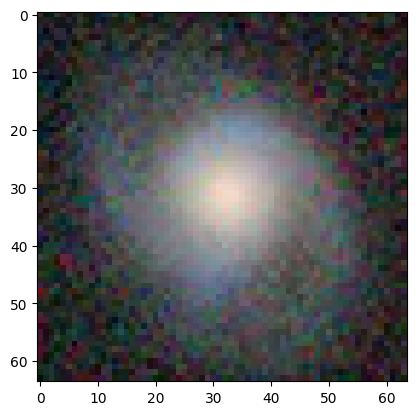

In [195]:
plt.imshow(images[4488])

In [197]:
## search for bad galaxy
max(results), results.index(max(results)) 

(121.60615539550781, 2460)

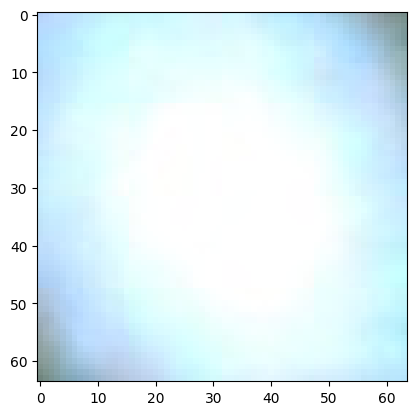

In [198]:
plt.imshow(images[2460])

In [ ]:
show_images(noise_images, noise_labels, num_rows=2, num_columns=5)

# Task: Genereate new images that look like the Milky Way